In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

from incendio.core import BaseModel

In [ ]:
class Model(BaseModel):
    
    def __init__(self):
        super().__init__()
        self.pad = nn.ReflectionPad2d(2)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.adapt = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.conv1(self.pad(x))
        x = F.leaky_relu(x)
        x = self.conv2(self.pad(x))
        x = F.leaky_relu(x)
        x = self.adapt(x)
        x = self.fc(x.squeeze())
        return torch.sigmoid(x)
    
    
class Model2(BaseModel):

    def __init__(self, c_in, c_outs):
        super().__init__()
        dims = [c_in] + c_outs
        self.enc = nn.Sequential(*[nn.Sequential(nn.ReflectionPad2d(2),
                                   nn.Conv2d(*(c_in, c_out), kernel_size=5),
                                   nn.LeakyReLU())
                                   for c_in, c_out in zip(dims, dims[1:])])
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(c_outs[-1], 1)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.pool(x)
        print(x.shape)
        x = x.squeeze()
        print(x.shape)
        return torch.sigmoid(self.fc(x))

In [ ]:
m2 = Model2(3, [8, 16, 32])
m2

Model2(
  (enc): Sequential(
    (0): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
m1 = Model()
m1

Model(
  (pad): ReflectionPad2d((2, 2, 2, 2))
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
x = torch.randint(255, (2, 3, 4, 4)).float()
x

tensor([[[[242., 170., 160., 117.],
          [154.,   2., 186., 243.],
          [151.,  47.,  33., 201.],
          [163., 199., 114., 197.]],

         [[213., 203., 234., 193.],
          [ 22., 209., 192.,  71.],
          [ 39.,  24., 200., 219.],
          [172., 170., 102., 136.]],

         [[160.,  23.,  98.,  46.],
          [  5.,  63.,  40., 184.],
          [206., 126., 126.,  49.],
          [236., 196., 218.,  43.]]],


        [[[ 20.,  74., 165., 111.],
          [203.,  71.,  98., 210.],
          [167., 178.,  25.,  93.],
          [207., 109., 228.,   9.]],

         [[ 22., 150., 237., 171.],
          [188.,  34., 214.,  87.],
          [ 92., 200., 179., 242.],
          [137.,  76., 213., 157.]],

         [[222., 102., 126.,  55.],
          [207., 195., 234.,  98.],
          [222.,  90.,  40., 117.],
          [ 30., 211., 191., 221.]]]])

In [ ]:
x[0].shape

torch.Size([3, 4, 4])

In [ ]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0) / 255)
    plt.show()

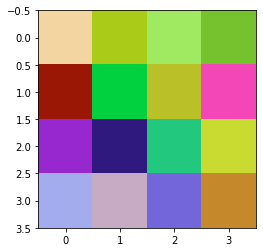

In [ ]:
show_img(x[0])

In [ ]:
x[0].shape

torch.Size([3, 4, 4])

In [ ]:
x.shape

torch.Size([2, 3, 4, 4])

In [ ]:
pad = nn.ReflectionPad2d(2)
x_pad = pad(x)
x_pad.shape

torch.Size([2, 3, 8, 8])

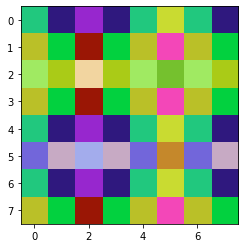

In [ ]:
show_img(x_pad[0])

In [ ]:
class ReflectionPaddedConv2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, padding=1, 
                 kernel_size=3, stride=1, bias=True, **kwargs):
        super().__init__()
        self.reflect = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride, padding=0, bias=bias)
    
    def forward(self, x):
        x = self.reflect(x)
        return self.conv(x)

In [ ]:
rc = ReflectionPaddedConv2d(in_channels=3, out_channels=3)
nn.init.constant_(rc.conv.weight, 1)
nn.init.constant_(rc.conv.bias, 0)

Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

In [ ]:
r = nn.Conv2d(3, 3, kernel_size=3, padding=1, padding_mode='zeros', bias=True)
nn.init.constant_(r.weight, 1)
nn.init.constant_(r.bias, 0)
x_p = r(x)
x_p.shape

torch.Size([2, 3, 4, 4])

In [ ]:
z[0] == x_p[0]

tensor([[[False, False, False, False],
         [False,  True,  True, False],
         [False,  True,  True, False],
         [False, False, False, False]],

        [[False, False, False, False],
         [False,  True,  True, False],
         [False,  True,  True, False],
         [False, False, False, False]],

        [[False, False, False, False],
         [False,  True,  True, False],
         [False,  True,  True, False],
         [False, False, False, False]]])

In [ ]:
nn.Conv2d.__doc__

'Applies a 2D convolution over an input signal composed of several input\n    planes.\n\n    In the simplest case, the output value of the layer with input size\n    :math:`(N, C_{\\text{in}}, H, W)` and output :math:`(N, C_{\\text{out}}, H_{\\text{out}}, W_{\\text{out}})`\n    can be precisely described as:\n\n    .. math::\n        \\text{out}(N_i, C_{\\text{out}_j}) = \\text{bias}(C_{\\text{out}_j}) +\n        \\sum_{k = 0}^{C_{\\text{in}} - 1} \\text{weight}(C_{\\text{out}_j}, k) \\star \\text{input}(N_i, k)\n\n\n    where :math:`\\star` is the valid 2D `cross-correlation`_ operator,\n    :math:`N` is a batch size, :math:`C` denotes a number of channels,\n    :math:`H` is a height of input planes in pixels, and :math:`W` is\n    width in pixels.\n\n    * :attr:`stride` controls the stride for the cross-correlation, a single\n      number or a tuple.\n\n    * :attr:`padding` controls the amount of implicit zero-paddings on both\n      sides for :attr:`padding` number of points for e